# Linear Regression

Linear regression is used for finding linear relationship between a continuous value target and one or more predictors.
$y = h_\theta(x) = \theta^T \phi(x)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
# to load MATLAB file
import scipy.io as sio
from IPython.display import display, Markdown, Math

%matplotlib inline

### Dataset

In [2]:
dataset1 = sio.loadmat('lr_dataset')

In [3]:
dataset1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_trn', 'X_tst', 'Y_trn', 'Y_tst'])

In [4]:
# Extracting training and testing data
X_train, y_train = np.matrix(dataset1['X_trn']), np.matrix(dataset1['Y_trn'])
X_test, y_test = np.matrix(dataset1['X_tst']), np.matrix(dataset1['Y_tst'])

In [5]:
X_train.shape, y_train.shape

((120, 1), (120, 1))

In [6]:
X_test.shape, y_test.shape

((100, 1), (100, 1))

**Data Visualization**

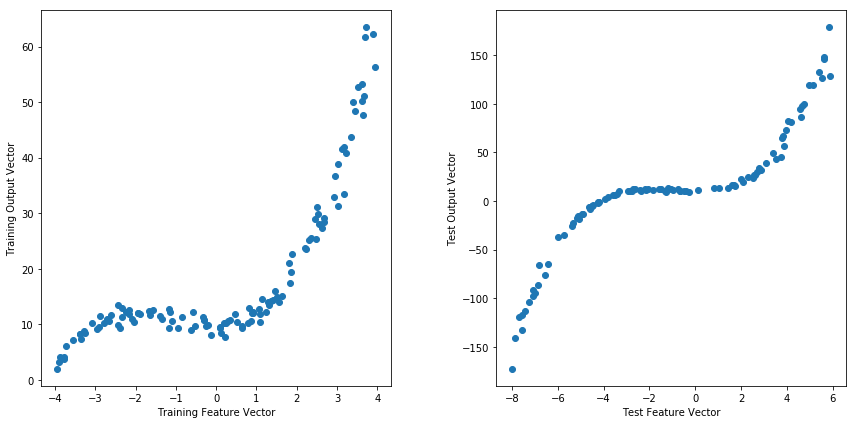

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(x= np.asarray(X_train), y=np.asarray(y_train))
ax[0].set_xlabel("Training Feature Vector")
ax[0].set_ylabel("Training Output Vector")

ax[1].scatter(x= np.asarray(X_test), y=np.asarray(y_test))
ax[1].set_xlabel("Test Feature Vector")
ax[1].set_ylabel("Test Output Vector")

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

## 1) Closed Form Solution Model

In [8]:
def linearRegression(X, y):
    """ Solves for weight vector θ using closed form equation
    
    θ = (X^T*X)^{-1}*X^T*y
    """
    var = np.dot(X.T, X)
    cov = np.dot(X.T, y)
    theta = np.dot(np.linalg.inv(var), cov)
    return theta

In [9]:
def plotPrediction(y, y_pred, title='Training set'):
    """ Scatter Plot: True Value (y) v/s Predicted Value (y_pred)"""
    plt.scatter(y, y_pred)
    plt.plot([min(y), max(y)], [min(y), max(y)], '--')
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(title)

In [10]:
def MSE(y, y_pred):
    """ Returns mean squared error between the actual and predicted output."""
    return np.mean(np.power((y - y_pred), 2))

**Adding Intercept term (a column with all 1s) to Feature Vectors**

In [11]:
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

**Calculates weight vector using the training data**

In [12]:
theta = linearRegression(X_train, y_train)
theta

matrix([[17.81209242],
        [ 4.8607913 ]])

MSE is 78.7011


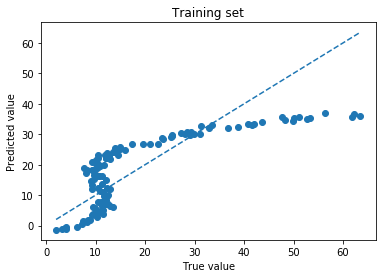

In [13]:
# Predicting the output vector for training data
y_train_predict = np.dot(X_train, theta)
# Calculating MSE on predicted and actual training output vector
train_mse = MSE(y_train, y_train_predict)
print('MSE is {:.4f}'.format(train_mse))
# plt.scatter requires array as inputs
plotPrediction(np.asarray(y_train), np.asarray(y_train_predict))

MSE is 2137.7926


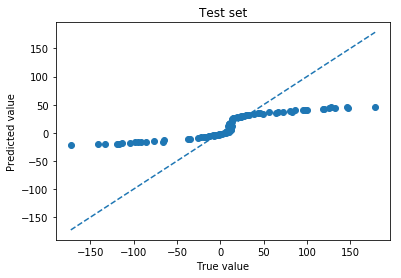

In [14]:
# Predicting the output vector for test data
y_test_predict = np.dot(X_test, theta)
# Calculating MSE on predicted and actual test output vector
test_mse = MSE(y_test, y_test_predict)
print('MSE is %.4f' % test_mse)
# plt.scatter requires array as inputs
plotPrediction(np.asarray(y_test), np.asarray(y_test_predict), 'Test set')

# 2) Stochastic Gradient Descent Model (Batch Size = m)

In [15]:
def computeCost(X, y, theta):
    # Cost fn = (|| Xθ - y||) ^ 2
    inner = np.power((np.dot(X, theta) - y), 2)
    return np.sum(inner) / (2 * len(X))

In [16]:
def stochasticGradientDescent(X, y, theta, alpha, minibatch_size, threshold=0.0001, iters=1500):
    """ optimizes weight vector (theta) with batch of minibatch_size in each iteration, until convergence"""
    
    # to store temp theta to perform simultaneous update in current iteration
    temp = np.matrix(np.zeros(theta.shape))
    parameters = theta.ravel().shape[1]
    cost = [np.inf]
    
    #for i in range(iters):
    while True:
        # iterating over feature matrix in batches
        for b in range(math.ceil(len(X)/minibatch_size)):
            # generates random samples without replacement, all unique
            random_idx = np.random.choice(len(X), size=minibatch_size, replace = False)

            # Get pair of (X, y) of the current minibatch/chunk
            X_mini = X[random_idx]
            y_mini = y[random_idx]
            #X_mini = X[batch:batch + minibatch_size]
            #y_mini = y[batch:batch + minibatch_size]
            
            error = np.dot(X_mini, theta) - y_mini
            
            # updated each parameter/weight in theta
            for j in range(parameters):
                # training element-wise multiplication of jth feature with the error
                term = np.multiply(error, X_mini[:,j])
                temp[j,0] = theta[j,0] - ((alpha / len(X_mini)) * np.sum(term))

            theta = temp
            
        cost.append(computeCost(X, y, theta))
        
        # check for convergence, i.e. if difference is cost within threshold
        if (cost[-2]-cost[-1]) > 0 and (cost[-2]-cost[-1]) < threshold:
            break
        
    return theta, cost

In [17]:
def plotCostperEpoch(cost):
    """ plots iteration v/s cost """
    fig, ax = plt.subplots(figsize=(14,8))

    plt.plot(np.arange(len(cost)), cost)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title('Error vs. Training Epoch')

In [18]:
def plotMSEmb(mse, start, end, step=1):
    """ plots mini-batch size v/s cost"""
    fig, ax = plt.subplots(figsize=(14,8))

    plt.plot(np.arange(start, end, step), mse)
    ax.set_xlabel('Mini-batch Size')
    ax.set_ylabel('MSE')
    ax.set_title('Error vs. Mini-batch Size')

## Modelling the Parameter θ

### i) 1-degree Polynomial

In [19]:
# adding quadratic term to the feature matrix
X_train_2d, X_test_2d = np.hstack((X_train, np.power(X_train[:, 1:], 2))), np.hstack((X_test, np.power(X_test[:, 1:], 2)))

**Closed-form**

In [20]:
theta_1d_closed = linearRegression(X_train, y_train)

display(Markdown(r'$\theta$' + ' for 1-degree polynomial (Closed-form)'))
display(theta_1d_closed)

$\theta$ for 1-degree polynomial (Closed-form)

matrix([[17.81209242],
        [ 4.8607913 ]])

In [21]:
y_train_predict_1d_closed = np.dot(X_train, theta_1d_closed)
print("MSE for Training set for 2-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_train), np.asarray(y_train_predict_1d_closed))))

y_test_predict_1d_closed = np.dot(X_test, theta_1d_closed)
print("MSE for Test set for 2-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_test), np.asarray(y_test_predict_1d_closed))))

MSE for Training set for 2-degree poynomial: 78.7011
MSE for Test set for 2-degree poynomial: 2137.7926


**Mini-batch Gradient Descent**

In [22]:
alpha = 0.00001        # learning-rate
iters = 1700
minibatch_size = 5
# initial weight vector
theta0_1d = np.matrix(np.zeros((X_train.shape[1], 1)))
display(Markdown(r'Initial  $\theta$ = ') , theta0_1d)

Initial  $\theta$ = 

matrix([[0.],
        [0.]])

In [23]:
theta_1d_sg, cost_1d_sg = stochasticGradientDescent(X_train, y_train, theta0_1d, alpha, minibatch_size)
display(Markdown(r'$\theta$' + ' for 1-degree polynomial (Minibatch Gradient Descent)'))
display(theta_1d_sg)

$\theta$ for 1-degree polynomial (Minibatch Gradient Descent)

matrix([[15.38405079],
        [ 4.94669569]])

In [24]:
y_train_predict_1d_sg = np.dot(X_train, theta_1d_sg)
mse_train_1d_sg = MSE(np.asarray(y_train), np.asarray(y_train_predict_1d_sg))
print("MSE for Training set for 1-degree poynomial: {0:.4f}".format(mse_train_1d_sg))

y_test_predict_1d_sg = np.dot(X_test, theta_1d_sg)
mse_test_1d_sg = MSE(np.asarray(y_test), np.asarray(y_test_predict_1d_sg))
print("MSE for Test set for 1-degree poynomial: {0:.4f}".format(mse_test_1d_sg))

MSE for Training set for 1-degree poynomial: 84.5677
MSE for Test set for 1-degree poynomial: 2108.1580


### ii) 2-degree Polynomial

In [25]:
# adding quadratic term to the feature matrix
X_train_2d, X_test_2d = np.hstack((X_train, np.power(X_train[:, 1:], 2))), np.hstack((X_test, np.power(X_test[:, 1:], 2)))

**Closed-form**

In [26]:
theta_2d_closed = linearRegression(X_train_2d, y_train)

display(Markdown(r'$\theta$' + ' for 2-degree polynomial (Closed-form)'))
display(theta_2d_closed)

$\theta$ for 2-degree polynomial (Closed-form)

matrix([[9.49203678],
        [4.79191663],
        [1.52906587]])

In [27]:
y_train_predict_2d_closed = np.dot(X_train_2d, theta_2d_closed)
print("MSE for Training set for 2-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_train), np.asarray(y_train_predict_2d_closed))))

y_test_predict_2d_closed = np.dot(X_test_2d, theta_2d_closed)
print("MSE for Test set for 2-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_test), np.asarray(y_test_predict_2d_closed))))

MSE for Training set for 2-degree poynomial: 24.7419
MSE for Test set for 2-degree poynomial: 4413.5868


**Mini-batch Gradient Descent**

In [28]:
alpha = 0.00001        # learning-rate
iters = 1700
minibatch_size = 5
# initial weight vector
theta0_2d = np.matrix(np.zeros((X_train_2d.shape[1], 1)))
display(Markdown(r'Initial  $\theta$ = ') , theta0_2d)

Initial  $\theta$ = 

matrix([[0.],
        [0.],
        [0.]])

In [29]:
theta_2d_sg, cost_2d_sg = stochasticGradientDescent(X_train_2d, y_train, theta0_2d, alpha, minibatch_size)
display(Markdown(r'$\theta$' + ' for 2-degree polynomial (Minibatch Gradient Descent)'))
display(theta_2d_sg)

$\theta$ for 2-degree polynomial (Minibatch Gradient Descent)

matrix([[2.19764482],
        [4.58252471],
        [2.30444254]])

In [30]:
y_train_predict_2d_sg = np.dot(X_train_2d, theta_2d_sg)
mse_train_2d_sg = MSE(np.asarray(y_train), np.asarray(y_train_predict_2d_sg))
print("MSE for Training set for 2-degree poynomial: {0:.4f}".format(mse_train_2d_sg))

y_test_predict_2d_sg = np.dot(X_test_2d, theta_2d_sg)
mse_test_2d_sg = MSE(np.asarray(y_test), np.asarray(y_test_predict_2d_sg))
print("MSE for Test set for 2-degree poynomial: {0:.4f}".format(mse_test_2d_sg))

MSE for Training set for 2-degree poynomial: 48.4183
MSE for Test set for 2-degree poynomial: 6299.8320


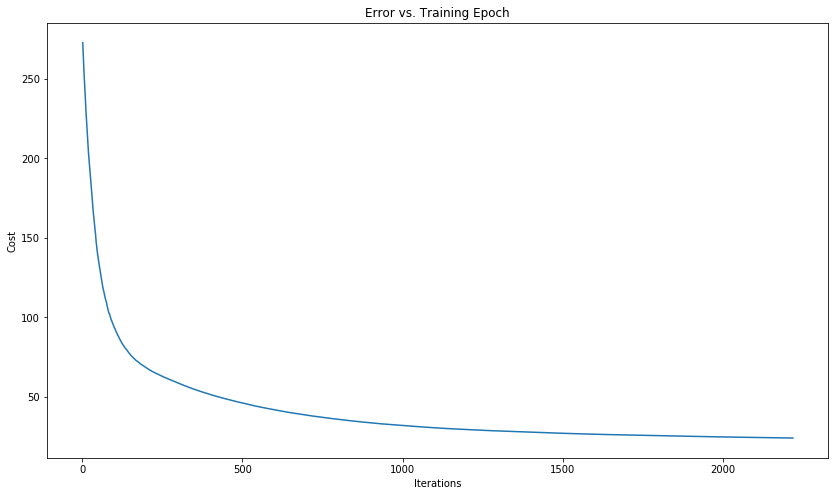

In [31]:
plotCostperEpoch(cost_2d_sg)

In [32]:
# MSE for different mini-batch sizes
mse_2d_sg = []
for mb in range(1,10):
    theta_2d_sg, _ = stochasticGradientDescent(X_train_2d, y_train, theta0_2d, alpha, mb)
    y_test_predict_2d_sg = np.dot(X_test_2d, theta_2d_sg)
    mse_2d_sg.append(MSE(np.asarray(y_test), np.asarray(y_test_predict_2d_sg)))

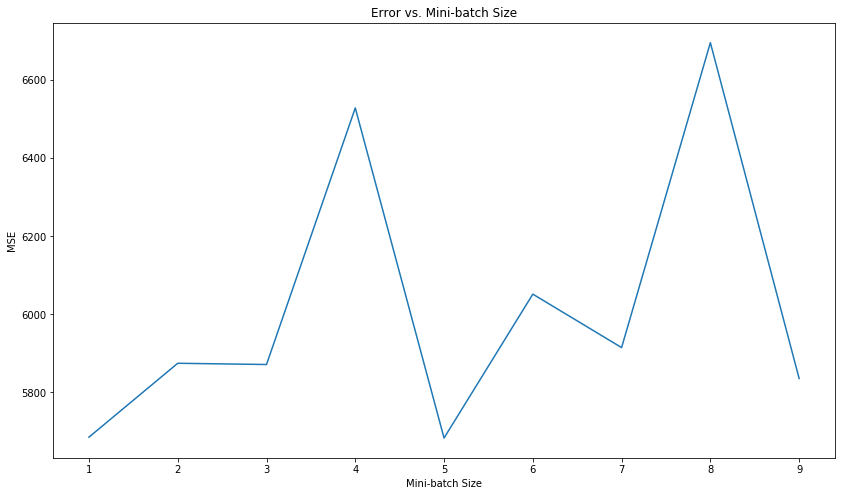

In [33]:
plotMSEmb(mse_2d_sg, 1, 10)

### ii) 3-degree Polynomial

In [34]:
# adding quadratic and cubic term to the feature matrix
X_train_3d = np.hstack((X_train, np.power(X_train[:, 1:], 2), np.power(X_train[:, 1:], 3)))
X_test_3d = np.hstack((X_test, np.power(X_test[:, 1:], 2), np.power(X_test[:, 1:], 3)))

**Closed-form**

In [35]:
theta_3d_closed = linearRegression(X_train_3d, y_train)

display(Markdown(r'$\theta$' + ' for 3-degree polynomial (Closed-form)'))
display(theta_3d_closed)

$\theta$ for 3-degree polynomial (Closed-form)

matrix([[10.00815033],
        [ 0.20418927],
        [ 1.47413164],
        [ 0.47320168]])

In [36]:
y_train_predict_3d_closed = np.dot(X_train_3d, theta_3d_closed)
print("MSE for Training set for 3-degree poynomial: {0:.4f}".format(MSE(np.asarray(y_train), np.asarray(y_train_predict_3d_closed))))

y_test_predict_3d_closed = np.dot(X_test_3d, theta_3d_closed)
print("MSE for Test set for 3-degree poynomial: {0:.4f}".format(MSE(np.asarray(y_test), np.asarray(y_test_predict_3d_closed))))

MSE for Training set for 3-degree poynomial: 3.9679
MSE for Test set for 3-degree poynomial: 53.8311


**Mini-batch Gradient Descent**

In [37]:
alpha = 0.0001        # learning-rate
iters = 1700
minibatch_size = 10
# initial weight vector
theta0_3d = np.matrix(np.zeros((X_train_3d.shape[1], 1)))
display(Markdown(r'Initial  $\theta$ = ') , theta0_3d)

Initial  $\theta$ = 

matrix([[0.],
        [0.],
        [0.],
        [0.]])

In [38]:
theta_3d_sg, cost_3d_sg = stochasticGradientDescent(X_train_3d, y_train, theta0_3d, alpha, minibatch_size)
display(Markdown(r'$\theta$' + ' for 3-degree polynomial (Minibatch Gradient Descent)'))
display(theta_3d_sg)

$\theta$ for 3-degree polynomial (Minibatch Gradient Descent)

matrix([[2.57352864],
        [0.31620319],
        [2.23912554],
        [0.45077895]])

In [39]:
y_train_predict_3d_sg = np.dot(X_train_3d, theta_3d_sg)
mse_train_3d_sg = MSE(np.asarray(y_train), np.asarray(y_train_predict_3d_sg))
print("MSE for Training set for 3-degree poynomial: {0:.4f}".format(mse_train_3d_sg))

y_test_predict_3d_sg = np.dot(X_test_3d, theta_3d_sg)
mse_test_3d_sg = MSE(np.asarray(y_test), np.asarray(y_test_predict_3d_sg))
print("MSE for Test set for 3-degree poynomial: {0:.4f}".format(mse_test_3d_sg))

MSE for Training set for 3-degree poynomial: 28.1723
MSE for Test set for 3-degree poynomial: 472.5005


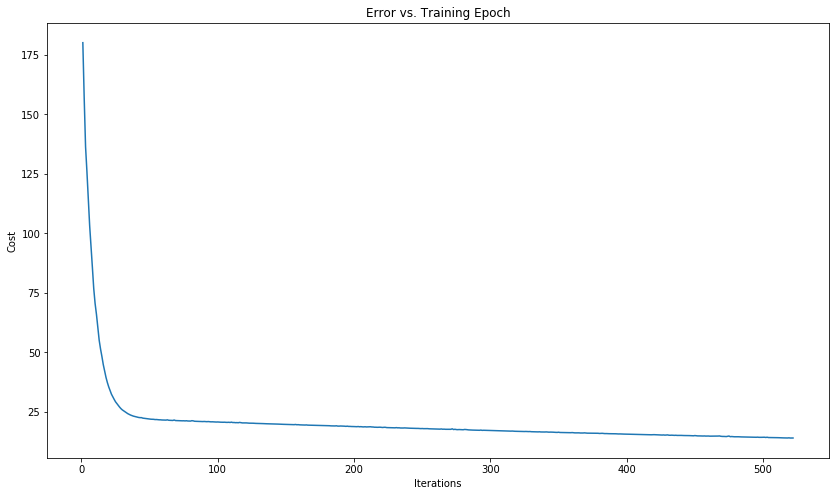

In [40]:
plotCostperEpoch(cost_3d_sg)

In [41]:
# MSE for different mini-batch sizes
mse_3d_sg = []
for mb in range(3, 10, 2):
    theta_3d_sg, _ = stochasticGradientDescent(X_train_3d, y_train, theta0_3d, alpha, mb)
    y_test_predict_3d_sg = np.dot(X_test_3d, theta_3d_sg)
    mse_3d_sg.append(MSE(np.asarray(y_test), np.asarray(y_test_predict_3d_sg)))

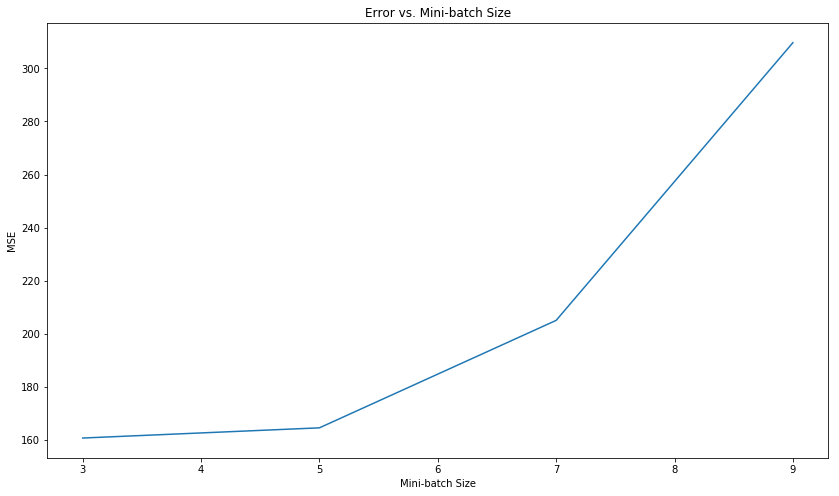

In [42]:
plotMSEmb(mse_3d_sg, 3, 10, 2)

### iii) 5-degree Polynomial

In [43]:
# adding 2, 3, 4 and 5 degree terms
X_train_5d = np.hstack((X_train, np.power(X_train[:, 1:], 2), np.power(X_train[:, 1:], 3), 
                        np.power(X_train[:, 1:], 4), np.power(X_train[:, 1:], 5)))
X_test_5d = np.hstack((X_test, np.power(X_test[:, 1:], 2), np.power(X_test[:, 1:], 3), 
                       np.power(X_test[:, 1:], 4), np.power(X_test[:, 1:], 5)))

**Closed-form**

In [44]:
theta_5d_closed = linearRegression(X_train_5d, y_train)

display(Markdown(r'$\theta$' + ' for 5-degree polynomial (Closed-form)'))
display(theta_5d_closed)

$\theta$ for 5-degree polynomial (Closed-form)

matrix([[ 9.84545670e+00],
        [ 2.03644970e-01],
        [ 1.57564738e+00],
        [ 4.75176601e-01],
        [-7.40094164e-03],
        [-1.77139419e-04]])

In [45]:
y_train_predict_5d_closed = np.dot(X_train_5d, theta_5d_closed)
print("MSE for Training set for 5-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_train), np.asarray(y_train_predict_5d_closed))))

y_test_predict_5d_closed = np.dot(X_test_5d, theta_5d_closed)
print("MSE for Test set for 5-degree poynomial: {0:.4f}"
      .format(MSE(np.asarray(y_test), np.asarray(y_test_predict_5d_closed))))

MSE for Training set for 5-degree poynomial: 3.9469
MSE for Test set for 5-degree poynomial: 41.5094


**Mini-batch Gradient Descent**

In [46]:
alpha = 0.000001       # learning-rate
iters = 1000
minibatch_size = 5
# initial weight vector
theta0_5d = np.matrix(np.zeros((X_train_5d.shape[1], 1)))
display(Markdown(r'Initial  $\theta$ = ') , theta0_5d)

Initial  $\theta$ = 

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [47]:
theta_5d_sg, cost_5d_sg = stochasticGradientDescent(X_train_5d, y_train, theta0_5d, alpha, minibatch_size, threshold=0.00001)
display(Markdown(r'$\theta$' + ' for 5-degree polynomial (Minibatch Gradient Descent)'))
display(theta_5d_sg)

$\theta$ for 5-degree polynomial (Minibatch Gradient Descent)

matrix([[0.4670395 ],
        [0.13111453],
        [1.02254532],
        [0.41199255],
        [0.10525139],
        [0.00574782]])

In [48]:
y_train_predict_5d_sg = np.dot(X_train_5d, theta_5d_sg)
mse_train_5d_sg = MSE(np.asarray(y_train), np.asarray(y_train_predict_5d_sg))
print("MSE for Training set for 5-degree poynomial: {0:.4f}".format(mse_train_5d_sg))

y_test_predict_5d_sg = np.dot(X_test_5d, theta_5d_sg)
mse_test_5d_sg = MSE(np.asarray(y_test), np.asarray(y_test_predict_5d_sg))
print("MSE for Test set for 5-degree poynomial: {0:.4f}".format(mse_test_5d_sg))

MSE for Training set for 5-degree poynomial: 73.3477
MSE for Test set for 5-degree poynomial: 5797.3780


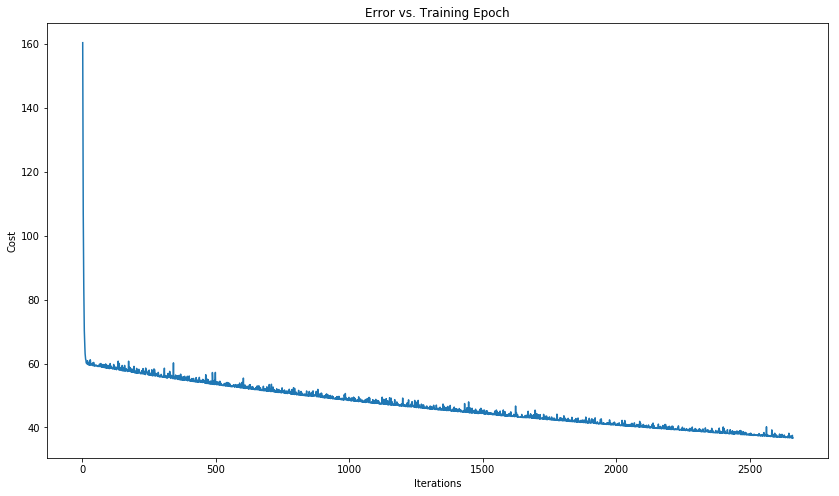

In [49]:
plotCostperEpoch(cost_5d_sg)

In [50]:
# MSE for different mini-batch sizes
mse_5d_sg = []
for mb in range(3,10,2):
    theta_5d_sg, _ = stochasticGradientDescent(X_train_5d, y_train, theta0_5d, alpha, mb)
    y_test_predict_5d_sg = np.dot(X_test_5d, theta_5d_sg)
    mse_5d_sg.append(MSE(np.asarray(y_test), np.asarray(y_test_predict_5d_sg)))

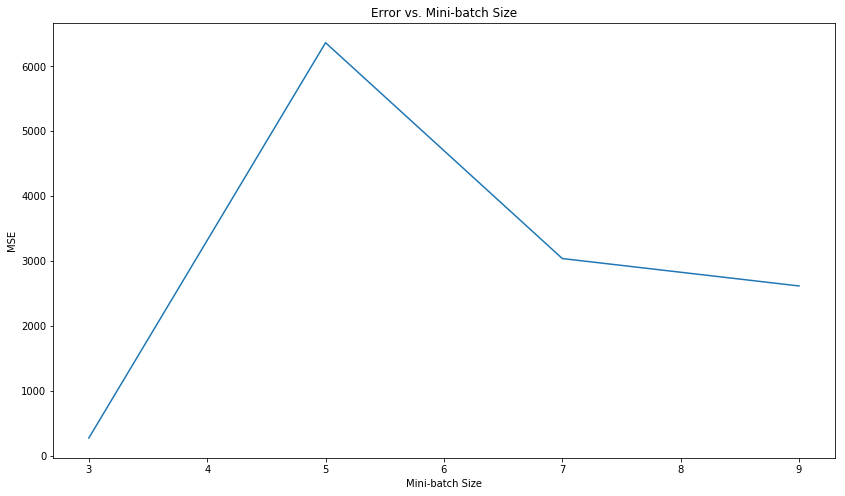

In [51]:
plotMSEmb(mse_5d_sg, 3, 10, 2)

## MSE w.r.t. Number of features

In machine learning, you split your data into a training set and a test set. The training set is used to fit the model (adjust the models parameters), the test set is used to evaluate how well your model will do on unseen data.

We have added more features to the input data by using higher-degree polynomials, which will reduce the training error (and may be test error), but after a point will result into **Overfitting**.

In [52]:
x_data = [1, 2, 3, 5]
y_train_data = [mse_train_1d_sg, mse_train_2d_sg, mse_train_3d_sg, mse_train_5d_sg]
y_test_data = [mse_test_1d_sg, mse_test_2d_sg, mse_test_3d_sg, mse_test_5d_sg]

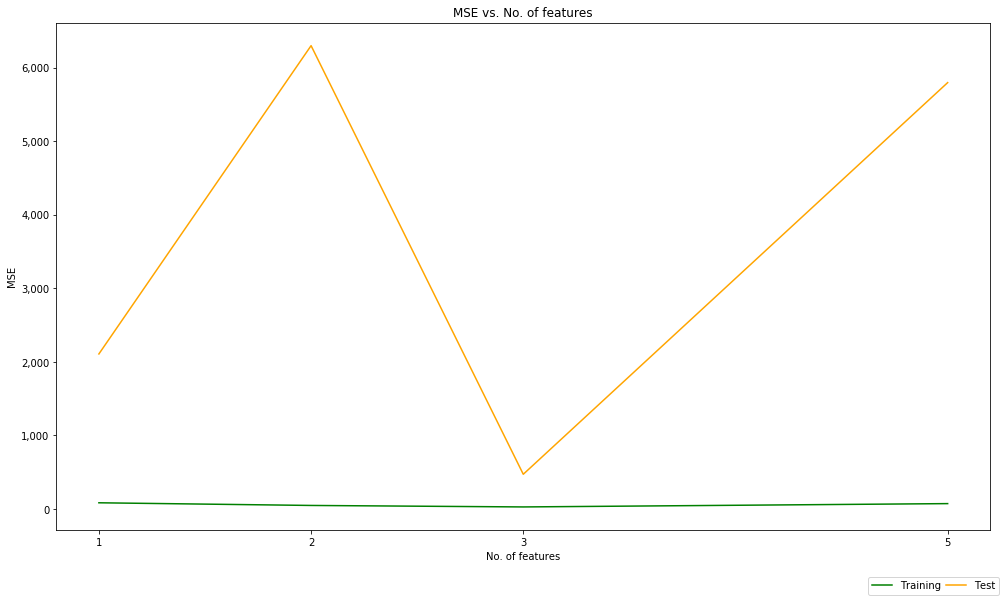

In [53]:
import matplotlib.ticker as tkr

fig, ax = plt.subplots(figsize=(14,8))

plt.plot(x_data, y_train_data, color='green', label='Training')
plt.plot(x_data, y_test_data, color='orange', label='Test')

ax.set_xlabel('No. of features')
ax.set_ylabel('MSE')
ax.set_title('MSE vs. No. of features')

ax.set_xticks(x_data)                   # Set the locations of the tick marks
ax.set_xticklabels(x_data)              # Set the text values of the tick labels

ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

fig.tight_layout()

plt.legend(bbox_to_anchor=(1, 0), loc="upper right", bbox_transform=fig.transFigure,
           ncol=2, columnspacing=0.5)
plt.show()

**Overfitting:** If we have too many features, the learned hypothesis may fit the training data very well, but failed to generalize on test dataset (as observed above). 

On the same lines, because of increase in number of features, the model now have high-variance i.e. very sensitive to the training data.

Moreover, for the dataset in consideration, 3 seems to be a good number of features with best performance on test data.